<a href="https://colab.research.google.com/github/rahiakela/natural-language-processing-case-studies/blob/bert-transformer-labs/BERT_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT: Sentiment Classification with Pre-Trained Language Models using Ktrain


We’ll use [ktrain](https://github.com/amaiya/ktrain), a lightweight wrapper to train and use pre-trained DL models using the TensorFlow library Keras. ktrain provides a straightforward process for all steps, from obtaining the dataset and the pre-trained BERT to fine-tuning it for the classification task.



## Setup

In [ ]:
%%shell

# install ktrain 
pip install ktrain

In [3]:
import tensorflow as tf
import ktrain
from ktrain import text

import os.path

import pandas as pd
import io
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load dataset
dataset = pd.read_csv("data.csv")
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


In [5]:
# discard unwanted column
data = dataset[["text", "airline_sentiment"]]
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## STEP 1: Preprocessing

In [6]:
# checking target value and its count
data["airline_sentiment"].value_counts()

negative    1617
neutral      510
positive     372
Name: airline_sentiment, dtype: int64

In [7]:
# checking the shape
data.shape

(2499, 2)

In [8]:
# check the total length of text 
data["text"].str.len().sum()

257971

In [9]:
# checking the total unique words
results = Counter()
data['text'].str.lower().str.split().apply(results.update)
print(len(results))

8204


In [10]:
# label one-hot encoding
data = pd.get_dummies(data, columns=["airline_sentiment"])
data.head()

,text,airline_sentiment_negative,airline_sentiment_neutral,airline_sentiment_positive
0,@VirginAmerica What @dhepburn said.,0,1,0
1,@VirginAmerica plus you've added commercials t...,0,0,1
2,@VirginAmerica I didn't today... Must mean I n...,0,1,0
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0


In [11]:
# rename one-hot colum name
data = data.rename(columns={"airline_sentiment_negative":"negative", "airline_sentiment_neutral":"neutral", "airline_sentiment_positive":"positive"})
data.head()

,text,negative,neutral,positive
0,@VirginAmerica What @dhepburn said.,0,1,0
1,@VirginAmerica plus you've added commercials t...,0,0,1
2,@VirginAmerica I didn't today... Must mean I n...,0,1,0
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0


In [12]:
data.shape

(2499, 4)

First, we use the texts_from_df function to load and preprocess the data in to arrays that can be directly fed into a neural network model.

We set val_pct as 0.1, which will automatically sample 10% of the data for validation.

We are using the BERT model (i.e., 'bert'), so we should use preprocess_mode='bert'.

In [13]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(data, 
                                                                    "text", 
                                                                    label_columns=["negative", "neutral", "positive"],
                                                                    preprocess_mode='bert',
                                                                    val_pct=0.1,
                                                                    max_features=250000,
                                                                    maxlen=170,
                                                                    ngram_range=1
                                                                    )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


##STEP 2: Loading a pre trained BERT and wrapping it in a ktrain.learner object

The next step is to load the pre-trained BERT model and fine-tune it for this dataset.

Next, we instantiate a Learner object and call the lr_find and lr_plot methods to help identify a good learning rate.

In [14]:
model = text.text_classifier("bert", (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

Is Multi-Label? False
maxlen is 170
done.


In [15]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
375/375 [==============================] - 175s 418ms/step - loss: 0.9650 - accuracy: 0.6135
Epoch 2/1024
375/375 [==============================] - 158s 423ms/step - loss: 0.6822 - accuracy: 0.7053
Epoch 3/1024
375/375 [==============================] - 160s 425ms/step - loss: 0.8920 - accuracy: 0.6450
Epoch 4/1024
375/375 [==============================] - 53s 141ms/step - loss: 3.6276 - accuracy: 0.5065


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


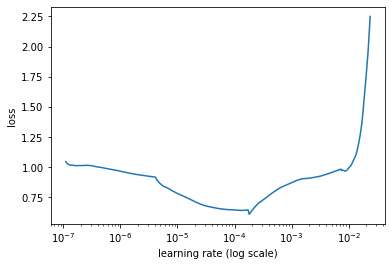

In [16]:
learner.lr_plot()

## STEP 3: Training and Tuning the model's parameters

Now we will train a text classifier using the BERT pre-trained model.

In [17]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(2e-5, 10)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
375/375 [==============================] - 186s 453ms/step - loss: 0.7376 - accuracy: 0.6910 - val_loss: 0.4617 - val_accuracy: 0.8080
Epoch 2/10
375/375 [==============================] - 167s 445ms/step - loss: 0.4252 - accuracy: 0.8248 - val_loss: 0.4132 - val_accuracy: 0.8280
Epoch 3/10
375/375 [==============================] - 167s 446ms/step - loss: 0.2612 - accuracy: 0.9040 - val_loss: 0.4314 - val_accuracy: 0.8560
Epoch 4/10
375/375 [==============================] - 168s 447ms/step - loss: 0.1340 - accuracy: 0.9542 - val_loss: 0.5841 - val_accuracy: 0.8080
Epoch 5/10
375/375 [==============================] - 167s 446ms/step - loss: 0.0705 - accuracy: 0.9787 - val_loss: 1.1457 - val_accuracy: 0.7680
Epoch 6/10
375/375 [==============================] - 168s 447ms/step - loss: 0.0782 - accuracy: 0.9742 - val_loss: 0.6376 - val_accuracy: 0.8360
Epoch 7/10
375/375 [==============================] - 167s 44

**As can be seen, our model yields a validation accuracy of 85.60 after 3rd epoch and then it is oscillating and not improving, so we need to search diffrent parameters like learning rate etc.**

## STEP-4: Making prediction on unseen data

Let's make some predictions on new data.

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [19]:
data = [
  " I booked a flight a while back to travel in March of 2020. But COVID-19 happened. I received a voucher for flight credits and was able to convert it back to cash to get my refund on my card. From March 2020 to now December 2020 I have still only received half of my refund. There is no number for Americans to call so I am stuck emailing. Everything went fine and I was initially told my refund would be processed. Months went by and I had only received half of it in May. I emailed again in July and by August or September I was told in 14 to 20 business days I would receive the other half. Over a month went by and nothing. I contacted once more in November and this time they sent “a receipt as proof that the payment was sent out” I guess they got tired of hearing from me and the next time I try to make a claim they will say they it was already sent out and the receipt is proof. They might has well has returned my flight credits. Choose another airline, these people are ripoffs. They will not refund your money.",
  "Worst Customer service I have experienced, ever. Its been more than 6 months and still not been able to fully recover refund for cancelled flight back in March 2020. Every time you call, you get told different information, no reply to emails. Eventually received some funds, but not the full amount due to their error, It takes another 14 to 20 working days apparently to receive funds, so after waiting long again, its quite disappointing to find out only tiny amount has been refunded again, another error. Why do I have to beg for money that I am entitled to? Avoid if you can",
  "Airlines cancelled my flight due to covid restrictions which is understandable. But they did not inform me it was cancelled luckily I had checked the airport site to see it was cancelled.",
  "The wont say in the email that IF you don't check in online then you must pay at the airport to check in. Such a cheap way to make money! So misleading. The staff isn't helpful at all. I will never fly with this terrible airline again!",
  "No problem except leg room which is rather uncomfortable if you are somewhat tall (5' 8 and my husband is 6'0) and it was very warm on the plane. Coming back what really bothered me was that going to the restroom early on in the flight the trash was full and the pump soap was empty. Someone had thrown bars of soap onto the counter. A 13 hour flight with guessing 300 people. Not very sanitary. Staff were polite and courteous. Good entertainment choices. Food average but I'm not the best judge for that. I'm not sure I would like to fly this airline again given a choice.",
  "Very attentive service needs were taken care of before you asked and very good food although I have had even better food on other THY flights. My real issue is with the business class seat sleeping comfort on the A340-300.I am not sure at what angle the seat reclines but it is pretty nasty I was annoyed because the ticket price was pretty high."
]

predictor.predict(data)

['negative', 'negative', 'negative', 'negative', 'negative', 'negative']